# Visualizing Geo-location clusters

## Import general packages

In [2]:
import pandas as pd

## Read in the Data

In [4]:
dCust = pd.read_csv("data/Customers_lat_long.csv")
dCust.head(10)

shipment_id   latitude  longitude
0      1398677  24.832347  67.041684
1      1398678  24.891330  67.173614
2      1398679  24.885776  67.029861
3      1398680  24.953500  67.065186
4      1398681  24.902006  67.084562
5      1398682  24.918781  67.055526
6      1398683  24.907132  67.059081
7      1398684  24.836915  67.192790
8      1398685  24.921633  67.021526
9      1398686  24.888671  67.036864

In [5]:
dCust.describe()

shipment_id     latitude    longitude
count  3.129000e+03  3129.000000  3129.000000
mean   1.400241e+06    24.901229    67.083814
std    9.034088e+02     0.049580     0.058945
min    1.398677e+06    24.780150    66.937702
25%    1.399459e+06    24.862622    67.043100
50%    1.400241e+06    24.903333    67.069969
75%    1.401023e+06    24.938851    67.135544
max    1.401805e+06    25.035790    67.224474

## Set initial parameters for map

### Import folium package

In [7]:
import folium
from folium.plugins import MarkerCluster   

### Set map parameters

In [8]:
# Choose centre-point coordintes for map

mid_lat = dCust['latitude'].median()
mid_long = dCust['longitude'].median()
print(mid_lat)
print(mid_long)

24.903333249637715
67.06996880471706


### Test the map

In [9]:

map = folium.Map(location=[mid_lat, mid_long],
                 zoom_start=10,
                 height=600,
                 control_scale=True)
map

### Simple Marker on Map

In [11]:

folium.Marker(
     location=[mid_lat, mid_long],
     popup="My Central Retail Location",
     icon=folium.Icon(icon='globe',color='red',prefix='fa')
).add_to(map)


map

### Adding Markers from DataFrame

In [12]:

for i, row in dCust.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=row["shipment_id"],
        tooltip=row["shipment_id"]
        ).add_to(map)
map

## K-means clustering of lat longs

In [13]:
type(dCust['longitude'])

pandas.core.series.Series

In [14]:
dCust['longitude']

0       67.041684
1       67.173614
2       67.029861
3       67.065186
4       67.084562
          ...    
3124    67.150081
3125    67.029030
3126    67.047617
3127    67.155970
3128    67.047617
Name: longitude, Length: 3129, dtype: float64

In [15]:
print(type(dCust[['longitude']]))  #KMeans needs a "2D-array" and Series is 1D, needs to have an index to assign to clusters
dCust[['longitude']]

<class 'pandas.core.frame.DataFrame'>


longitude
0     67.041684
1     67.173614
2     67.029861
3     67.065186
4     67.084562
...         ...
3124  67.150081
3125  67.029030
3126  67.047617
3127  67.155970
3128  67.047617

[3129 rows x 1 columns]

### Find best k on longitude only

In [16]:
## Import required libraries
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  #sci-kit learn package KMeans module will be used
from yellowbrick.cluster import KElbowVisualizer

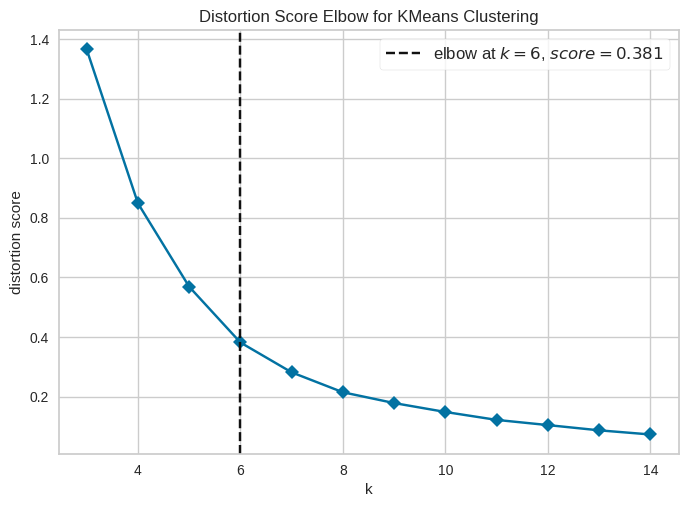

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
kBegin = 3
kEnd = 15
km = KMeans(random_state=120)
visualizer = KElbowVisualizer(km, k=(kBegin,kEnd), timings=False)
visualizer.fit(dCust[['longitude']]) 
#NOTE: SQUARE BRACKETS WITHIN SQUARE BRACKETS TO GIVE KMEANS A 2D-ARRAY.
visualizer.show()

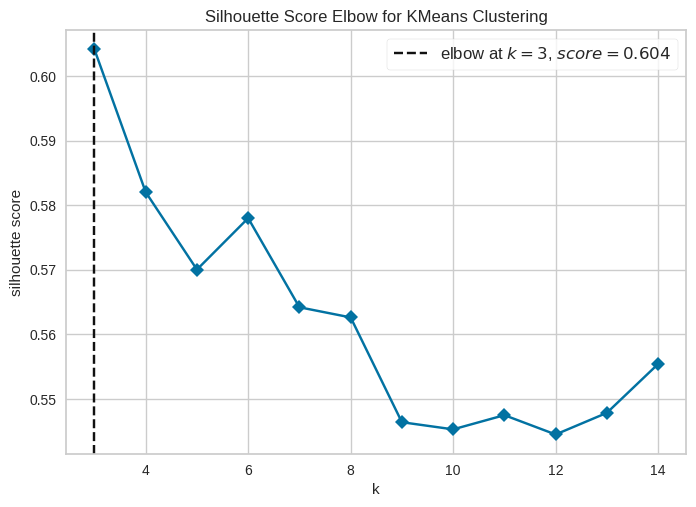

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [19]:
vizElbowSil = KElbowVisualizer(km,
                               metric='silhouette',
                               k=(kBegin, kEnd),
                               timings=False)
vizElbowSil.fit(dCust[['longitude']])
vizElbowSil.show()

### Cluster on chosen best k

In [20]:
dCust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   shipment_id  3129 non-null   int64  
 1   latitude     3129 non-null   float64
 2   longitude    3129 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 73.5 KB


In [21]:
len(dCust['shipment_id'].unique())

3129

In [22]:
colsToClust = ['latitude','longitude']
km = KMeans(n_clusters=12).fit(dCust[colsToClust])

### Save cluster centroids as coordinates for map

In [23]:
km.cluster_centers_

array([[24.87767665, 67.14976387],
       [24.94178812, 67.06278244],
       [24.92676777, 67.10446193],
       [24.9940173 , 67.06609577],
       [24.86806765, 67.01728148],
       [24.85252962, 67.07698569],
       [24.87999397, 67.19282518],
       [24.82753106, 67.03140341],
       [24.94305364, 66.9836168 ],
       [24.95042924, 67.14292688],
       [24.90557728, 67.04931224],
       [24.82943556, 67.15661384]])

In [24]:
dClusters = pd.DataFrame(km.cluster_centers_,
                         columns=['lat_cent','long_cent']
            )

In [25]:
dClusters

lat_cent  long_cent
0   24.877677  67.149764
1   24.941788  67.062782
2   24.926768  67.104462
3   24.994017  67.066096
4   24.868068  67.017281
5   24.852530  67.076986
6   24.879994  67.192825
7   24.827531  67.031403
8   24.943054  66.983617
9   24.950429  67.142927
10  24.905577  67.049312
11  24.829436  67.156614

### Tag each shipment with chosen clustering

In [26]:
dCust['cluster'] = km.labels_
dCust.head()

shipment_id   latitude  longitude  cluster
0      1398677  24.832347  67.041684        7
1      1398678  24.891330  67.173614        6
2      1398679  24.885776  67.029861        4
3      1398680  24.953500  67.065186        1
4      1398681  24.902006  67.084562        2

### Visualizing the K clusters

#### Ensure map object reset to contain only starting marker(s)

In [27]:
map = folium.Map(location=[mid_lat, mid_long],
                 zoom_start=12,
                 height=700,
                 control_scale=True)
folium.Marker(
    location=[mid_lat, mid_long],
     popup="My Central Retail Location",
     icon=folium.Icon(icon='home',color='red')
).add_to(map)
map

#### First add the cluster markers on the map

In [28]:
MCList = []  #list to collect the MarkerCluster objects allocated to map
for i, row in dClusters.iterrows():
    mc = MarkerCluster(name=i).add_to(map)  #row['cluster']
    MCList.append(mc)
##END for on dClusters

#### Then add the clusters to its cluster marker

In [35]:
for i, row in dCust.iterrows():
    # Convert the cluster value to an integer before using it as an index for MCList
    cluster_index = int(row['cluster'])
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        tooltip=row["shipment_id"]
    ).add_to(MCList[cluster_index])

# Add a layer control to the map for managing the markers
map.add_child(folium.LayerControl())

# Display the map
map

### Save the map 

In [36]:
map.save("clusters.html")